# Discord Data Analyzer

This is a tool that will analyze your discord data much deeper than standard
tools, primarily through using ML to categorize all of your messages.

## How to use

### Getting Your Discord Data
1. Go on discord -> User Settings -> Privacy & Security -> "Request all of my Data"
2. Discord will eventually send you an email with a link that will let you download your "package.zip". It contains all of your discord data and all the messages you have ever sent.

### Prepare Google Colab

1. In the toolbar at the top of this page, click on the Runtime drop down menu
2. "Change Runtime Type"
3. Select "GPU"

### Upload Your Discord Data To This Notebook
1. Go to the "Files" tab on the left of this page.

> 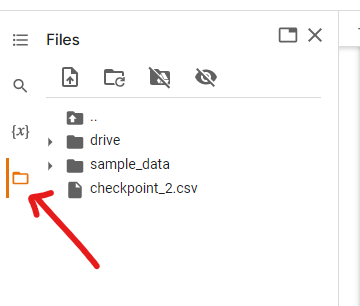
2. Upload your "package.zip" file

### Run this notebook
1. In the toolbar at the top of this page, click on the Runtime drop down menu
2. "Run all"

OR press `CTRL + F9`

In [13]:
# @title After running, this should say CUDA. If it's not on CUDA, this will take literally forever to run
# If this doesn't say "cuda", change your Runtime to "GPU" using the toolbar at the top of this page
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [265]:
# @title Params

TimeZone = "US/Eastern" #@param {type:"string"}
date = pd.Timestamp.now(tz=TimeZone)
print("See if your timezone is correct: ", date)

See if your timezone is correct:  2023-03-02 14:32:18.543846-05:00


In [18]:
#@title Get Data

GetPackageFromDrive = "yes" #@param ["yes", "no"]
GoogleDriveLocation = "/content/drive/MyDrive/package.zip" #@param {type:"string"}

if GetPackageFromDrive == "yes" and GoogleDriveLocation is not None:
  from google.colab import drive
  drive.mount('/content/drive', force_remount=True)
  import shutil
  shutil.copyfile(GoogleDriveLocation, "package.zip")

import os
import zipfile

if not os.path.isdir("package"):
  assert os.path.isfile("package.zip")
  with zipfile.ZipFile("package.zip", 'r') as zip_ref:
      zip_ref.extractall("package")
assert os.path.isdir("package")

Mounted at /content/drive


# Initialization

In [59]:
# @title Common Data Visualization Util

import seaborn as sns

sns.set_theme()
sns.set_context("notebook")

def group_and_transform_data(df, group_by, transformer):
  buckets = df.groupby(group_by)
  buckets = {b[0]: transformer(b[1]) for b in buckets}
  bucketed_df = pd.DataFrame.from_dict(buckets, orient='index')
  return bucketed_df

import matplotlib.ticker
import calendar

day_of_week_formatter = matplotlib.ticker.FuncFormatter(lambda x, pos: calendar.day_name[int(x) - 1])
month_name_formatter = matplotlib.ticker.FuncFormatter(lambda x, pos: calendar.month_name[int(x) + 1])

In [19]:
# @title Load Data

import json

channel_name_map = None
with open("package/messages/index.json") as index:
  channel_name_map = json.load(index)

import os
import pandas as pd
from tqdm import tqdm_notebook

df_acc = pd.DataFrame()
subdirs = next(os.walk('package/messages'))[1]
for subdir in tqdm_notebook(subdirs):
  df = pd.read_csv(os.path.join("package/messages", subdir, "messages.csv"))
  df["Channel"] = channel_name_map.get(subdir, None)
  df = df.drop('Attachments', axis=1)
  df = df.drop('ID', axis=1)
  df_acc = df_acc.append(df)
df = df_acc
assert 'Timestamp' in df, 'Contents' in df
print(f'{len(df.index)} Messages loaded')

<ipython-input-19-2eb22085deb9>:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for subdir in tqdm_notebook(subdirs):


  0%|          | 0/743 [00:00<?, ?it/s]

287189 Messages loaded


In [75]:
from pandas.api.types import is_string_dtype
import datetime

if is_string_dtype(df['Timestamp']):
  remove_timezone_colon = lambda d: d[:-3] + d[-2:]
  timestamp_to_datetime = lambda s: datetime.datetime.strptime(s, "%Y-%m-%d %H:%M:%S%z" if len(s) == 24 else "%Y-%m-%d %H:%M:%S.%f%z")
  df['Timestamp'] = df['Timestamp'].apply(remove_timezone_colon).apply(timestamp_to_datetime)
  df['Timestamp'] = df['Timestamp'].tz_convert(tz=TimeZone)

In [11]:
# Record information about the pre-cleaned data, mostly for Basic Information Visualization

import pandas as pd

unprocessed_df_info = pd.DataFrame({
    'Timestamp': df['Timestamp'],
    'ContentsLength': df['Contents'].str.len()
})

In [87]:
# @title Clean Data

import datetime

df.reset_index(inplace=True)

df.dropna(subset=["Contents"], inplace=True)

contents = df['Contents']
contents = contents.str.strip()

# emotes eg <:moon2S:901721403550728193> | <a:moon2S:901721403550728193> (a means animated) | :moon2S: -> moon2S
contents = contents.str.replace('(<a?)?:([\w\d]+):(\d{18}>)?', r'\2')
# user tag
contents = contents.str.replace('<@[!&]?[0-9]+>', '[Name]')

df['Contents'] = contents

<ipython-input-87-87fb47462180>:21: FutureWarning: The default value of regex will change from True to False in a future version.
  contents = contents.str.replace('(<a?)?:([\w\d]+):(\d{18}>)?', r'\2')
<ipython-input-87-87fb47462180>:23: FutureWarning: The default value of regex will change from True to False in a future version.
  contents = contents.str.replace('<@[!&]?[0-9]+>', '[Name]')


In [8]:
# @title Filter Data

def drop(df, mask) -> int:
  original_df_size = len(df.index)
  df.drop(df[mask].index, inplace=True)
  dropped_rows = original_df_size - len(df.index)
  return dropped_rows

def drop_by_regex(df, regex) -> int:
  if isinstance(regex, list) or isinstance(regex, tuple) or isinstance(regex, set):
    regex = '|'.join(regex)
  match_mask = df["Contents"].str.match(regex)
  return drop(df, match_mask)


URL_REGEX = "^https?:\/\/(?:www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b(?:[-a-zA-Z0-9()@:%_\+.~#?&\/=]*)$"
URL_NO_HTTP_REGEX = "^[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b(?:[-a-zA-Z0-9()@:%_\+.~#?&//=]*)$"
EMAIL_REGEX = "^[\w\-\.]+@([\w\-]+\.)+[\w\-]{2,4}$"

EMOTICON_REGEX = "(\:\w+\:|\<[\/\\]?3|[\(\)\\\D|\*\$][\-\^]?[\:\;\=]|[\:\;\=B8][\-\^]?[3DOPp\@\$\*\\\)\(\/\|])(?=\s|[\!\.\?]|$)"

filters = [
    {
        "name": "URL",
        "regex": {URL_REGEX, URL_NO_HTTP_REGEX, EMAIL_REGEX},
    },
    {
        "name": '"OK"',
        "regex": "^(?i)(ok(ay|ie|ie dokie)?)$"
    },
    {
        "name": "Emojis",
        "regex": EMOTICON_REGEX
    },
    {
        "name": "Code",
        "regex": "```(.|\n)*```"
    }
]

df.dropna(subset=["Contents"], inplace=True)

for f in filters:
  dropped = drop_by_regex(df, f["regex"])

drop(df, df['Contents'].str.len() <= 2)

# Basic Information Visualization

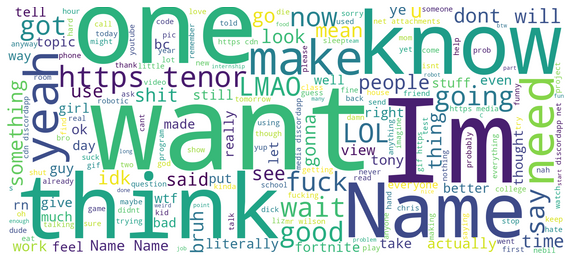

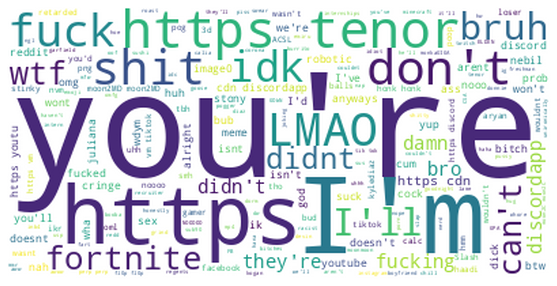

In [245]:
# @title Wordclouds

!pip install -q wordcloud

import matplotlib.pyplot as plt

COMMON_WORDS_URL = "https://raw.githubusercontent.com/first20hours/google-10000-english/master/google-10000-english-no-swears.txt"

def show_wordcloud(wordcloud):
  plt.figure(figsize=(10,5))
  plt.imshow(wordcloud, interpolation='spline36')
  plt.axis("off")
  plt.show()

def make_wordcloud():
  from wordcloud import WordCloud
  from wordcloud import ImageColorGenerator
  from wordcloud import STOPWORDS

  text = " ".join(i for i in df["Contents"])
  stopwords = set(STOPWORDS)
  show_wordcloud(WordCloud(width=1800, height=800, stopwords=stopwords, background_color="white").generate(text))
  
  import requests
  response = requests.get(COMMON_WORDS_URL)
  stopwords = {w.decode() for w in response.iter_lines()}
  show_wordcloud(WordCloud(stopwords=stopwords, background_color="white").generate(text))

make_wordcloud()

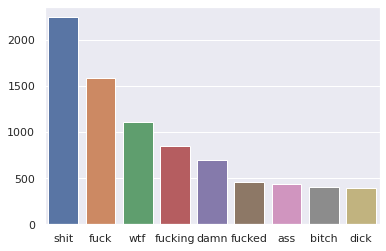

In [272]:
# @title Most Used Profanities

import requests

PROFANE_WORDS_URL = "https://raw.githubusercontent.com/zacanger/profane-words/master/words.json"

profane_words = requests.get(PROFANE_WORDS_URL).json()
profane_words_regex = f'(?<![a-zA-Z0-9])({"|".join(profane_words)})(?![a-zA-Z0-9])'
profane_words_matches = df['Contents'].str.extract(profane_words_regex)

profane_words_matches = profane_words_matches[profane_words_matches.values != np.NaN].value_counts().nlargest(9)
pwm_labels = [e[0] for e in profane_words_matches.index.to_list()]
sns.barplot(x=pwm_labels, y=profane_words_matches.values);

## Number of Messages Sent Over Time

In [41]:
total_messages_sent = len(unprocessed_df_info.index)
print(f'{total_messages_sent} total messages sent')
total_characters_sent = int(unprocessed_df_info["ContentsLength"].sum())
print(f'{total_characters_sent} total characters sent')
print(f'{total_characters_sent // total_messages_sent} characters per message on average')

287189 total messages sent
6634318 total characters sent
23 characters per message on average


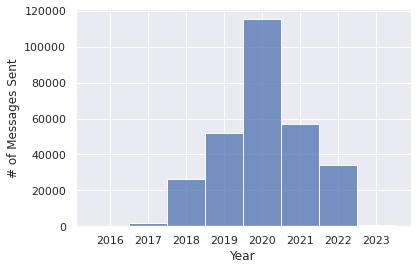

In [35]:
ax = sns.histplot(data=unprocessed_df_info['Timestamp'].dt.year, discrete=True)
ax.set(xlabel="Year", ylabel="# of Messages Sent");

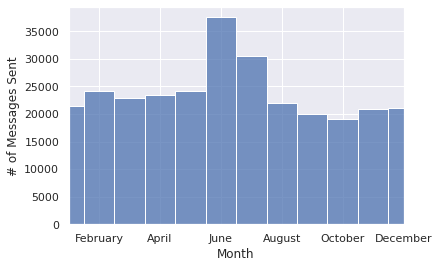

In [66]:
ax = sns.histplot(data=unprocessed_df_info['Timestamp'].dt.month, discrete=True)
ax.set(xlabel="Month", ylabel="# of Messages Sent");
ax.xaxis.set_major_formatter(month_name_formatter)
ax.set(xlim=(1, 12));

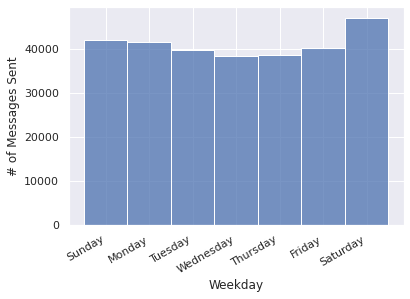

In [62]:
count_by_week_ax = sns.histplot(data=unprocessed_df_info['Timestamp'].dt.weekday, discrete=True)

count_by_week_ax.set(xlabel="Weekday", ylabel="# of Messages Sent")
count_by_week_ax.xaxis.set_major_formatter(day_of_week_formatter)
for label in count_by_week_ax.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')

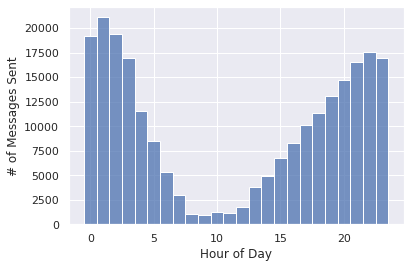

In [23]:
ax = sns.histplot(data=unprocessed_df_info['Timestamp'].dt.hour, discrete=True)
ax.set(xlabel="Hour of Day", ylabel="# of Messages Sent");

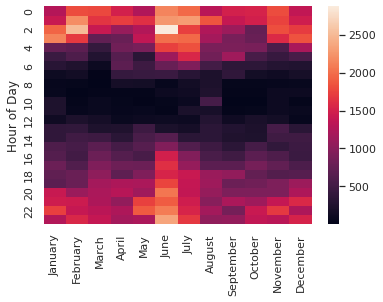

In [33]:
import pandas as pd

month_vs_hour_count = pd.DataFrame({
    calendar.month_name[m]: unprocessed_df_info[unprocessed_df_info['Timestamp'].dt.month == m]['Timestamp'].dt.hour.value_counts() for m in range(1, 13)
})
ax = sns.heatmap(data=month_vs_hour_count);
ax.set(ylabel="Hour of Day");

## Message Lengths

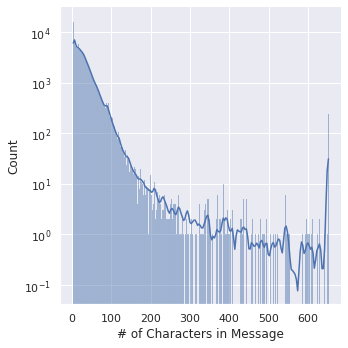

In [60]:
import numpy as np

content_lengths = unprocessed_df_info['ContentsLength'].copy()
cutoff = content_lengths.quantile(.999)
content_lengths[content_lengths >= cutoff] = cutoff
ax = sns.displot(data=content_lengths, binwidth=1, log_scale=(False, True), kde=True)
ax.set(xlabel="# of Characters in Message");

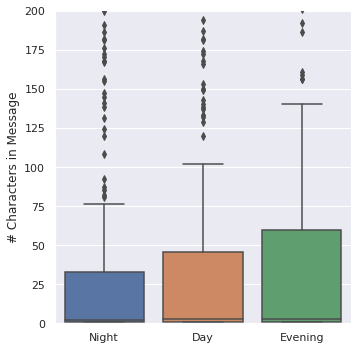

In [63]:
import pandas as pd

def get_message_counts_in_timeframe(hour_start, hour_end):
  mask = (unprocessed_df_info['Timestamp'].dt.hour >= hour_start) & (unprocessed_df_info['Timestamp'].dt.hour <= hour_end)
  return unprocessed_df_info[mask]['ContentsLength'].value_counts()

hour_vs_message_length = {
    "Night": get_message_counts_in_timeframe(0, 7),
    "Day": get_message_counts_in_timeframe(8, 12 + 9),
    "Evening": get_message_counts_in_timeframe(12 + 9, 24)
}
hour_vs_message_length = pd.DataFrame(hour_vs_message_length)
ax = sns.catplot(data=hour_vs_message_length, kind="box");
ax.set(ylabel="# Characters in Message", ylim=(0, 200));

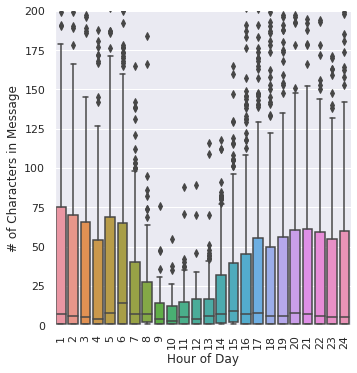

In [64]:
import pandas as pd

hour_vs_message_length = {
    h + 1: unprocessed_df_info[unprocessed_df_info['Timestamp'].dt.hour == h]['ContentsLength'].value_counts() for h in range(0, 24)
}
hour_vs_message_length = pd.DataFrame(hour_vs_message_length)
fg = sns.catplot(data=hour_vs_message_length, kind="box");
fg.set(xlabel="Hour of Day", ylabel="# of Characters in Message", ylim=(0, 200));
for axes in fg.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=90)

# GoEmotions Inference

This will take a long time. It takes about 24 minutes for my 280,000 messages.
Be patient :)

In [11]:
!pip install -q transformers

import torch;
from transformers import BertTokenizer, BertForSequenceClassification;

## Checkpoint 1

In [4]:
df.to_csv("checkpoint_1.csv")

In [2]:
import pandas as pd
df = pd.read_csv("checkpoint_1.csv")

# GoEmotions Data Visualization

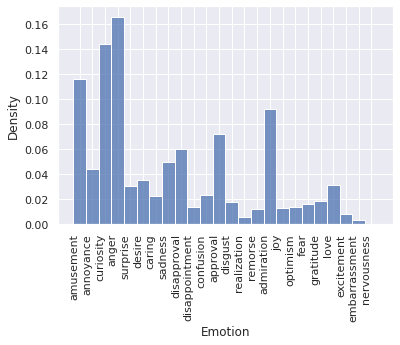

In [125]:
# @title Overall Emotion Profile
emotion_messages = df['Emotion'][df['Emotion'] != "neutral"]
ax = sns.histplot(data=emotion_messages, stat="density")
for label in ax.get_xticklabels(which='major'):
    label.set(rotation=90, horizontalalignment='right')

## Emotion Profile by Keyword

Use the textbox below to see the top emotions associated with the given text.

Press the "run" button in the cell below or CTRL+ENTER while the cell is highlighted to search.

56 matches


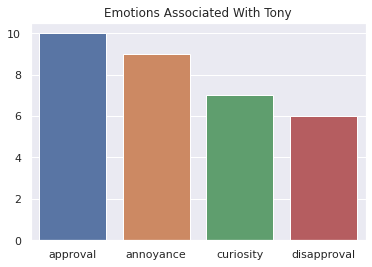

In [341]:
KeyWordSearchTerm = "Tony" #@param {type:"string"}

matches = df[(df['Emotion'] != "neutral") & df['Contents'].str.contains(KeyWordSearchTerm, "i")]
num_matches = len(matches.index)
print(f'{num_matches} matches')
if num_matches > 0:
  emotion_counts = matches['Emotion'].value_counts()
  num_emotions = len(emotion_counts.index)
  if num_emotions > 4:
    emotion_counts = emotion_counts.nlargest(4)
  sns.barplot(x=emotion_counts.index, y=emotion_counts.values).set(title=f'Emotions Associated With {KeyWordSearchTerm}')

# Sentiment Analysis Inference

The information GoEmotions gives is very fine-grained with 27 different emotions, but it is not that accurate. Instead of 27 emotions, sentiment analysis uses 3 categories - "positive", "negative", and "neutral" which is much more accurate and easier to visualize.

You can either reuse the results from GoEmotions for fast results, or use a different, more specialized model for more accurate results. The latter should not take nearly as long to compute as GoEmotions did. Use the checkbox under "Inference" to pick.

In [ ]:
UseDifferentModelForSentimentAnalysis = True #@param {type:"boolean"}

In [1]:
!pip install -q transformers

In [3]:
# @title Inference

def computeSentimentUsingAccurateModel():
  import torch
  from transformers import pipeline
  from tqdm import tqdm_notebook
  
  torch.cuda.empty_cache()

  sentiment_pipeline = pipeline(model="cardiffnlp/twitter-roberta-base-sentiment", device=0)
  content = [s[:min(len(s), 300)] for s in df['Contents'].to_list()]
  res = sentiment_pipeline(content, batch_size=100, truncation="only_first")
  label_map = {"LABEL_0": "negative", "LABEL_1":"neutral", "LABEL_2": "positive"}
  res = [label_map[x["label"]] for x in res]
  df['Sentiment'] = res

def convertGoEmotionsResultsToSentiment():
  sentiment_mapping = {
    "positive": ["amusement", "excitement", "joy", "love", "desire", "optimism", "caring", "pride", "admiration", "gratitude", "relief", "approval"],
    "negative": ["fear", "nervousness", "remorse", "embarrassment", "disappointment", "sadness", "grief", "disgust", "anger", "annoyance", "disapproval"],
    "neutral": ["realization", "surprise", "curiosity", "confusion", "neutral"]
  }
  sentiment_mapping = {v: k for k, V in sentiment_mapping.items() for v in V}

  df['Sentiment'] = df['Emotion'].map(sentiment_mapping)


if UseDifferentModelForSentimentAnalysis:
  computeSentimentUsingAccurateModel()
else:
  convertGoEmotionsResultsToSentiment()

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


### Checkpoint 2

In [5]:
df.to_csv("checkpoint_2.csv")

In [2]:
import pandas as pd
df = pd.read_csv("checkpoint_2.csv")

# Sentiment Analysis Visualization

In [77]:
import matplotlib.pyplot as plt
import numpy as np

def sentiment_table_to_positivity(df):
  counts = df[df["Sentiment"] != "neutral"]["Sentiment"].value_counts()
  percentages = 100 * counts / counts.sum()
  pos = percentages.get("positive", default=0)
  return pos

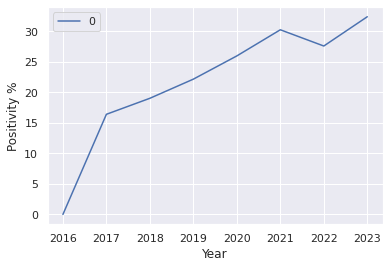

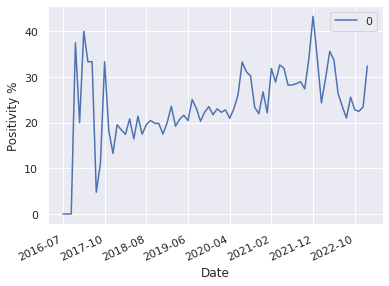

In [107]:
# @title Positivity Over Time
sentiment_over_time_by_year = group_and_transform_data(df, pd.Series(df['Timestamp'].dt.year), sentiment_table_to_positivity)
ax = sentiment_over_time_by_year.plot()
ax.set(xlabel="Year", ylabel="Positivity %");

sentiment_over_time_by_month = group_and_transform_data(df, pd.Series(df['Timestamp'].dt.strftime("%Y-%m")), sentiment_table_to_positivity)
ax = sentiment_over_time_by_month.plot()
ax.set(xlabel="Date", ylabel="Positivity %");
for label in ax.get_xticklabels(which='major'):
    label.set(rotation=25, horizontalalignment='right')

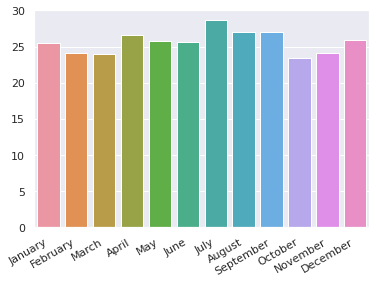

In [88]:
# @title Positivity vs Month of Year

sentiment_by_month = group_and_transform_data(df, pd.Series(df['Timestamp'].dt.month), sentiment_table_to_positivity)
month_ax = sns.barplot(x=sentiment_by_month.index, y=[e[0] for e in sentiment_by_month.values])
month_ax.xaxis.set_major_formatter(month_name_formatter)
for label in month_ax.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')

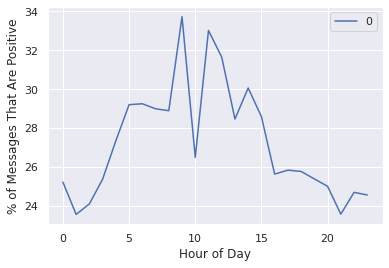

In [100]:
# @title Positivity vs Hour of Day

sentiment_by_hour = group_and_transform_data(df, pd.Series(df['Timestamp'].dt.hour), sentiment_table_to_positivity)
ax = sentiment_by_hour.plot()
ax.set(xlabel="Hour of Day", ylabel="% of Messages That Are Positive");

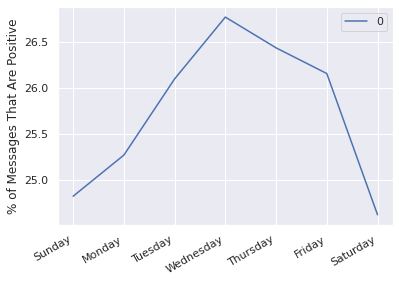

In [100]:
# @title Overall Positivity By Weekday
sentiment_by_day_of_week = group_and_transform_data(df, pd.Series(df['Timestamp'].dt.weekday), sentiment_table_to_positivity)
week_ax = sentiment_by_day_of_week.plot(kind='line', ylabel="Positivity %")
week_ax.xaxis.set_major_formatter(day_of_week_formatter)
for label in week_ax.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')

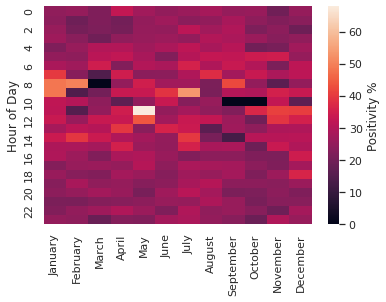

In [139]:
# @title Positivity Heatmap By Hour vs Month

import pandas as pd

def get_positivity_for_month_by_hour(df, m):
  filtered_rows = df[df['Timestamp'].dt.month == m]
  return group_and_transform_data(filtered_rows, filtered_rows['Timestamp'].dt.hour, sentiment_table_to_positivity).to_numpy()[:, 0]

month_vs_hour_count = {
    calendar.month_name[m]: get_positivity_for_month_by_hour(df, m) for m in range(1, 13)
}
month_vs_hour_count = pd.DataFrame(month_vs_hour_count)
ax = sns.heatmap(data=month_vs_hour_count, cbar_kws={'label': 'Positivity %'});
ax.set(ylabel="Hour of Day");

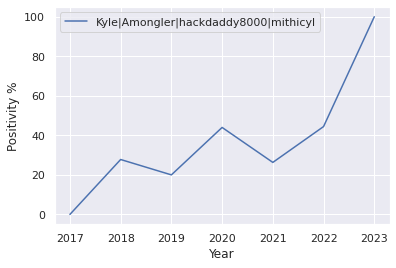

In [339]:
# @title Compare positivity over time between search terms

CommaSeparatedKeywords = "Kyle|Amongler|hackdaddy8000|mithicyl" #@param {type:"string"}
MakeAnonymous = False #@param {type:"boolean"}

keywords = [k.strip() for k in CommaSeparatedKeywords.split(r",")]
keywords_regex = [f'(?<![a-zA-Z0-9]){k}(?![a-zA-Z0-9])' for k in keywords]

def get_positivity_score_timeseries(df, keyword):
  filtered_rows = df[df['Contents'].str.contains("(?i)" + keyword, "i")]
  sentiment_over_time = group_and_transform_data(filtered_rows, pd.Series(filtered_rows['Timestamp'].dt.year), sentiment_table_to_positivity)
  return sentiment_over_time

keyword_sentiments = { keyword: get_positivity_score_timeseries(df, keyword) for keyword in keywords_regex}
labels = keywords
if MakeAnonymous:
  labels = ["Person " + str(i) for i in range(len(labels))]
keyword_sentiments = pd.concat(keyword_sentiments.values(), keys=labels, axis=1)
ax = sns.lineplot(data=keyword_sentiments)
ax.set(xlabel="Year", ylabel="Positivity %");